In [1]:
import lightgbm as lgb
import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import seaborn as sns

In [3]:
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Seaborn version: 0.13.2
Matplotlib version: 3.10.3


In [149]:
filepath = '../../../fs_corr_income_data'

### Loading Datasets

In [164]:
test_data_x60 = pd.read_csv(filepath + '/test/60/X_test.csv')
test_data_x60 = test_data_x60.drop(columns=['Unnamed: 0'], axis=1)
test_data_y60 = pd.read_csv(filepath + '/test/60/y_test.csv')
test_data_y60 = test_data_y60.drop(columns=['Unnamed: 0'], axis=1)

test_data_x70 = pd.read_csv(filepath + '/test/70/X_test.csv')
test_data_x70 = test_data_x70.drop(columns=['Unnamed: 0'], axis=1)
test_data_y70 = pd.read_csv(filepath + '/test/70/y_test.csv')
test_data_y70 = test_data_y70.drop(columns=['Unnamed: 0'], axis=1)

test_data_x80 = pd.read_csv(filepath + '/test/80/X_test.csv')
test_data_x80 = test_data_x80.drop(columns=['Unnamed: 0'], axis=1)
test_data_y80 = pd.read_csv(filepath + '/test/80/y_test.csv')
test_data_y80 = test_data_y80.drop(columns=['Unnamed: 0'], axis=1)

In [165]:
validation_60 = {}
validation_70 = {}
validation_80 = {}

for fold in range(0, 5):
    vdata_x60 = pd.read_csv(filepath + '/val/60/X_val_' + str(fold) + '.csv')
    vdata_x60 = vdata_x60.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y60 = pd.read_csv(filepath + '/val/60/y_val_' + str(fold) + '.csv')
    vdata_y60 = vdata_y60.drop(columns=['Unnamed: 0'], axis=1)
    validation_60[fold] = [vdata_x60, vdata_y60]

    vdata_x70 = pd.read_csv(filepath + '/val/70/X_val_' + str(fold) + '.csv')
    vdata_x70 = vdata_x70.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y70 = pd.read_csv(filepath + '/val/70/y_val_' + str(fold) + '.csv')
    vdata_y70 = vdata_y70.drop(columns=['Unnamed: 0'], axis=1)
    validation_70[fold] = [vdata_x70, vdata_y70]

    vdata_x80 = pd.read_csv(filepath + '/val/80/X_val_' + str(fold) + '.csv')
    vdata_x80 = vdata_x80.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y80 = pd.read_csv(filepath + '/val/80/y_val_' + str(fold) + '.csv')
    vdata_y80 = vdata_y80.drop(columns=['Unnamed: 0'], axis=1)
    validation_80[fold] = [vdata_x80, vdata_y80]

In [190]:
train_80[3]

[      Literacy rate, youth total (% of people ages 15-24) female
 0                                                   NaN         
 1                                                   NaN         
 2                                                   NaN         
 3                                             99.945793         
 4                                                   NaN         
 ...                                                 ...         
 1959                                          99.940514         
 1960                                                NaN         
 1961                                                NaN         
 1962                                                NaN         
 1963                                                NaN         
 
 [1964 rows x 1 columns],
       Maternal mortality ratio (national estimate, per 100,000 live births)
 0                                                  27.0                    
 1                        

In [166]:
train_60 = {}
train_70 = {}
train_80 = {}

for corr_idx, corr in enumerate(['60', '70', '80']):
    for fold in range(0, 5):
        tdata_x85 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_85.csv')
        tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y85 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_85.csv')
        tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x95 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_95.csv')
        tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y95 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_95.csv')
        tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

        tdata_x1 = pd.read_csv(filepath + '/train/' + corr + '/X_train_' + str(fold) + '_1.csv')
        tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
        tdata_y1 = pd.read_csv(filepath + '/train/' + corr + '/y_train_' + str(fold) + '_1.csv')
        tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

        if corr_idx == 0:
            train_60[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        if corr_idx == 1:
            train_70[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]
        else: train_80[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

In [193]:
for fold in train_60.keys():
    print(train_60[fold][0].shape, train_60[fold][2].shape, train_60[fold][4].shape)

(1570, 64) (1959, 96) (1964, 112)
(1532, 68) (1959, 105) (1964, 112)
(1573, 68) (1964, 103) (1964, 112)
(1573, 68) (1959, 103) (1964, 112)
(1528, 68) (1959, 103) (1964, 112)


In [194]:
for fold in train_70.keys():
    print(train_80[fold][0].shape, train_70[fold][2].shape, train_70[fold][4].shape)

(1964, 0) (1936, 38) (1964, 45)
(1964, 1) (1936, 44) (1964, 45)
(1964, 1) (1964, 43) (1964, 45)
(1964, 1) (1936, 43) (1964, 45)
(1964, 1) (1936, 43) (1964, 45)


In [191]:
for fold in train_80.keys():
    print(train_80[fold][0].shape, train_80[fold][2].shape, train_80[fold][4].shape)

(1964, 0) (1964, 7) (1964, 11)
(1964, 1) (1964, 10) (1964, 11)
(1964, 1) (1964, 10) (1964, 11)
(1964, 1) (1964, 10) (1964, 11)
(1964, 1) (1964, 7) (1964, 11)


In [167]:
import pickle
with open('../../../feature_selection_models/corr_60.pkl', 'rb') as f:
    corr_60 = pickle.load(f)
with open('../../../feature_selection_models/corr_70.pkl', 'rb') as f:
    corr_70 = pickle.load(f)
with open('../../../feature_selection_models/corr_80.pkl', 'rb') as f:
    corr_80 = pickle.load(f)

### Objective Function

In [171]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("number_trees", 10, 300)

    max_depth = trial.suggest_int("max_tree_depth", 3, 25)

    boosting_type = trial.suggest_categorical("boosting_type", ['gbdt', 'dart'])
    
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 0, 10)

    learning_rate = trial.suggest_float("learning_rate", 0, 1)
    l1_norm = trial.suggest_float("l1_norm", 0, 0.001)
    l2_norm = trial.suggest_float("l2_norm", 0, 0.001)

    lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity = -1, n_estimators=n_trees, boosting=boosting_type, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=l1_norm, reg_lambda=l2_norm, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq)
    trained_model = lgbm_model.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

##### Code Design

In [ ]:
for corr_idx, corr in enumerate([corr_60, corr_70, corr_80]):
    #for fold in range(0):
        fold = 0
        val_input_data_all_features = validation[fold][0].copy()
        val_input_data = val_input_data_all_features[list(corr)]
        print(corr_idx, val_input_data.shape)
        #val_input_data['setting'] = val_input_data['setting'].astype("category")
        #because lightgbm cannot handle the comma
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        for thresh_idx, thresh in enumerate(['1']):
            if thresh_idx != 0:
                continue
            train_input_data_all_features = train[fold][(thresh_idx+2) * 2].copy()
            train_input_data = train_input_data_all_features[list(corr)]
            #train_input_data['setting'] = train_input_data['setting'].astype("category")
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
            train_label = train[fold][(thresh_idx+2) * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            #Create a study object and optimize the objective function.
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
            best_model = lgb.LGBMRegressor(**study.best_params)
            best_model.fit(train_input_data, train_label)
            print(study.best_value)
            print(corr, fold, thresh)

#### Code Implementation

In [156]:
output_dir = '../../../feature_selection_models/by_country/lightgbm'

In [172]:
for corr_idx, corr in enumerate([corr_60, corr_70, corr_80]):
    validation_data = None
    training_data = None
    if corr_idx == 0:
        validation_data = validation_60
        training_data = train_60
    elif corr_idx == 1:
        validation_data = validation_70
        training_data = train_70
    elif corr_idx == 2:
        validation_data = validation_80
        training_data = train_80

    for fold in range(0, 5):
        val_input_data = validation_data[fold][0].copy()
        #because lightgbm cannot handle the comma
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation_data[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        for thresh_idx, thresh in enumerate(['85', '95', '1']):
            train_input_data = training_data[fold][thresh_idx * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh_idx * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            columns_needed = val_input_data.columns.intersection(train_input_data.columns)
            val_relevant_input = val_input_data[columns_needed]

            #Create a study object and optimize the objective function.
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
            best_model = lgb.LGBMRegressor(**study.best_params)
            best_model.fit(train_input_data, train_label)

            corr_name = ''
            if corr_idx == 0:
                corr_name = 'corr_60'
            elif corr_idx == 1:
                corr_name = 'corr_70'
            else: corr_name = 'corr_80'
            
            #save best model 
            joblib.dump(best_model, output_dir + '/best_model_' + corr_name + '_' + str(fold) + '_' + thresh +  '.pkl')
            joblib.dump(study.best_params, f"{output_dir}/best_params_{corr_name}_{fold}_{thresh}.pkl")

            # Save study for later visualization
            joblib.dump(study, f"{output_dir}/optuna_study_{corr_name}_{fold}_{thresh}.pkl")

            summary = {
                "dataset": str(fold) + '_' + thresh,
                "feature selection correlation" : corr_name,
                "fold" : fold,
                "threshold": thresh,
                "model": 'lightgbm',
                "best_params": study.best_params,
                "best_optuna_loss": study.best_value
            }

            with open(f"{output_dir}/results_{corr_name}_{fold}_{thresh}.json", "w") as f:
                json.dump(summary, f, indent=2)

[I 2025-08-08 08:52:16,168] A new study created in memory with name: no-name-c978ac99-8457-414a-8f4c-9047d496be49
[I 2025-08-08 08:52:16,468] Trial 0 finished with value: 8373.594193985931 and parameters: {'number_trees': 190, 'max_tree_depth': 7, 'boosting_type': 'gbdt', 'bagging_fraction': 0.5667781080502083, 'bagging_freq': 9, 'learning_rate': 0.12453390533186315, 'l1_norm': 0.0008521770278139976, 'l2_norm': 0.00062194305153277}. Best is trial 0 with value: 8373.594193985931.
[I 2025-08-08 08:52:17,944] Trial 1 finished with value: 9087.13061051043 and parameters: {'number_trees': 259, 'max_tree_depth': 23, 'boosting_type': 'dart', 'bagging_fraction': 0.3480231428234948, 'bagging_freq': 10, 'learning_rate': 0.6792914222788909, 'l1_norm': 0.000959928166275715, 'l2_norm': 0.0007295884191133392}. Best is trial 0 with value: 8373.594193985931.
[I 2025-08-08 08:52:19,176] Trial 2 finished with value: 8182.0325160227985 and parameters: {'number_trees': 218, 'max_tree_depth': 20, 'boosting

LightGBMError: Forced splits file includes feature index 0, but maximum feature index in dataset is -1

In [192]:
for fold in range(0, 5):
        val_input_data = validation_80[fold][0].copy()
        #because lightgbm cannot handle the comma
        val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        val_label = validation_80[fold][1].copy()
        val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        for thresh_idx, thresh in enumerate(['85', '95', '1']):
            if fold == 0 and thresh == '85':
                 continue
            
            train_input_data = train_80[fold][thresh_idx * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = train_80[fold][thresh_idx * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            columns_needed = val_input_data.columns.intersection(train_input_data.columns)
            val_relevant_input = val_input_data[columns_needed]

            #Create a study object and optimize the objective function.
            study = optuna.create_study(direction='minimize')
            study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
            best_model = lgb.LGBMRegressor(**study.best_params)
            best_model.fit(train_input_data, train_label)

            corr_name = ''
            if corr_idx == 0:
                corr_name = 'corr_60'
            elif corr_idx == 1:
                corr_name = 'corr_70'
            else: corr_name = 'corr_80'
            
            #save best model 
            joblib.dump(best_model, output_dir + '/best_model_' + corr_name + '_' + str(fold) + '_' + thresh +  '.pkl')
            joblib.dump(study.best_params, f"{output_dir}/best_params_{corr_name}_{fold}_{thresh}.pkl")

            # Save study for later visualization
            joblib.dump(study, f"{output_dir}/optuna_study_{corr_name}_{fold}_{thresh}.pkl")

            summary = {
                "dataset": str(fold) + '_' + thresh,
                "feature selection correlation" : corr_name,
                "fold" : fold,
                "threshold": thresh,
                "model": 'lightgbm',
                "best_params": study.best_params,
                "best_optuna_loss": study.best_value
            }

            with open(f"{output_dir}/results_{corr_name}_{fold}_{thresh}.json", "w") as f:
                json.dump(summary, f, indent=2)

[I 2025-08-08 10:58:02,316] A new study created in memory with name: no-name-ccbafb96-6bcd-445e-b586-2416c0817de3
[I 2025-08-08 10:58:02,513] Trial 0 finished with value: 13401.003754697893 and parameters: {'number_trees': 66, 'max_tree_depth': 9, 'boosting_type': 'gbdt', 'bagging_fraction': 0.3710130023548173, 'bagging_freq': 7, 'learning_rate': 0.7654751492556305, 'l1_norm': 0.0004946377118150416, 'l2_norm': 0.0009298443655050788}. Best is trial 0 with value: 13401.003754697893.
[I 2025-08-08 10:58:02,828] Trial 1 finished with value: 13468.742667291806 and parameters: {'number_trees': 214, 'max_tree_depth': 8, 'boosting_type': 'gbdt', 'bagging_fraction': 0.3478146835997361, 'bagging_freq': 10, 'learning_rate': 0.19536666236361921, 'l1_norm': 0.0002054568248783426, 'l2_norm': 0.0008629455639187609}. Best is trial 0 with value: 13401.003754697893.
[I 2025-08-08 10:58:04,570] Trial 2 finished with value: 13693.012776868316 and parameters: {'number_trees': 201, 'max_tree_depth': 19, 'bo

### Loading Models

#### Test values for all models

In [195]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Correlation 0.6', 'Threshold 85%', '1'), ('Correlation 0.6', 'Threshold 85%', '2'), ('Correlation 0.6', 'Threshold 85%', '3'), 
     ('Correlation 0.6', 'Threshold 85%', '4'), ('Correlation 0.6', 'Threshold 85%', '5'), ('Correlation 0.6', 'Threshold 95%', '1'), 
     ('Correlation 0.6', 'Threshold 95%', '2'), ('Correlation 0.6', 'Threshold 95%', '3'), ('Correlation 0.6', 'Threshold 95%', '4'), 
     ('Correlation 0.6', 'Threshold 95%', '5'), ('Correlation 0.6', 'None', '1'), ('Correlation 0.6', 'None', '2'), 
     ('Correlation 0.6', 'None', '3'), ('Correlation 0.6', 'None', '4'), ('Correlation 0.6', 'None', '5'), ('Correlation 0.7', 'Threshold 85%', '1'), 
     ('Correlation 0.7', 'Threshold 85%', '2'), ('Correlation 0.7', 'Threshold 85%', '3'), 
     ('Correlation 0.7', 'Threshold 85%', '4'), ('Correlation 0.7', 'Threshold 85%', '5'), ('Correlation 0.7', 'Threshold 95%', '1'), 
     ('Correlation 0.7', 'Threshold 95%', '2'), ('Correlation 0.7', 'Threshold 95%', '3'), ('Correlation 0.7', 'Threshold 95%', '4'), 
     ('Correlation 0.7', 'Threshold 95%', '5'), ('Correlation 0.7', 'None', '1'), ('Correlation 0.7', 'None', '2'), 
     ('Correlation 0.7', 'None', '3'), ('Correlation 0.7', 'None', '4'), ('Correlation 0.7', 'None', '5'), ('Correlation 0.8', 'Threshold 85%', '1'), 
     ('Correlation 0.8', 'Threshold 85%', '2'), ('Correlation 0.8', 'Threshold 85%', '3'), 
     ('Correlation 0.8', 'Threshold 85%', '4'), ('Correlation 0.8', 'Threshold 85%', '5'), ('Correlation 0.8', 'Threshold 95%', '1'), 
     ('Correlation 0.8', 'Threshold 95%', '2'), ('Correlation 0.8', 'Threshold 95%', '3'), ('Correlation 0.8', 'Threshold 95%', '4'), 
     ('Correlation 0.8', 'Threshold 95%', '5'), ('Correlation 0.8', 'None', '1'), ('Correlation 0.8', 'None', '2'), 
     ('Correlation 0.8', 'None', '3'), ('Correlation 0.8', 'None', '4'), ('Correlation 0.8', 'None', '5')],
    names=['Correlation Subset', 'Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Correlation Subset Missing Data Threshold Fold                         
Correlation 0.6    Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   None                   1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
Correlation 0.7    Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   None                   1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
Correlation 0.8    Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN
                   None                   1     NaN  NaN  NaN  NaN  NaN
                                          2     NaN  NaN  NaN  NaN  NaN
                                          3     NaN  NaN  NaN  NaN  NaN
                                          4     NaN  NaN  NaN  NaN  NaN
                                          5     NaN  NaN  NaN  NaN  NaN

In [196]:
best_parameters = {'Correlation 0.6' : {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}, 
                   'Correlation 0.7' : {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []},
                   'Correlation 0.8' : {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}}

In [ ]:
for corr_idx, corr in enumerate(['60', '70', '80']):
    testing_datax = None
    testing_datay = None
    training_data = None
    if corr_idx == 0:
        testing_datax = test_data_x60.copy()
        testing_datay = test_data_y60.copy()
        training_data = train_60
    elif corr_idx == 1:
        testing_datax = test_data_x70.copy()
        testing_datay = test_data_y70.copy()
        training_data = train_70
    elif corr_idx == 2:
        testing_datax = test_data_x80.copy()
        testing_datay = test_data_y80.copy()
        training_data = train_80
    
    testing_datax.columns = testing_datax.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    testing_datay.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    corr_name = ''
    table_corr_name = ''
    if corr_idx == 0:
        corr_name = 'corr_60'
        table_corr_name = 'Correlation 0.6'
    elif corr_idx == 1:
        corr_name = 'corr_70'
        table_corr_name = 'Correlation 0.7'
    else: 
        corr_name = 'corr_80'
        table_corr_name = 'Correlation 0.8'

    for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
        for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):

            if thresh == 0:
                name = '85'
            elif thresh == 1:
                name = '95'
            else: name = '1'

            best_params = joblib.load(f"{output_dir}/best_params_{corr_name}_{fold}_{name}.pkl")
            best_parameters[table_corr_name][thresh_name].append(best_params)

            train_input_data = training_data[fold][thresh_idx * 2].copy()
            train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

            train_label = training_data[fold][thresh_idx * 2 + 1].copy()
            train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

            columns_needed = testing_datax.columns.intersection(train_input_data.columns)
            to_test = testing_datax[columns_needed].copy()

            loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
            train_load = loaded_model.fit(train_input_data, train_label)
            prediction = train_load.predict(to_test)
            mse = mean_squared_error(prediction, testing_datay)
            mae = mean_absolute_error(prediction, testing_datay)
            rmse = np.sqrt(mse)
            r2 = r2_score(prediction, testing_datay)

            #to calculate mape
            num_predictions = len(prediction)
            mape = 0
            for p in range(0, num_predictions):
                mape += np.abs(prediction[p] - testing_datay.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(testing_datay.iloc[p]))
            mape = mape/num_predictions

            test_stat.loc[(table_corr_name, thresh_name, fold_num), 'MSE'] = mse
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAE'] = mae
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'RMSE'] = rmse
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'R2'] = r2
            test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_62787/2291085394.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_62787/2291085394.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(table_corr_name, thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_62787/2291085394.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

In [198]:
test_stats

MAPE        MAE  \
Correlation Subset Missing Data Threshold Fold                        
Correlation 0.6    Threshold 85%          1     0.451061  43.681138   
                                          2      0.45239  38.469492   
                                          3     0.476097  40.546543   
                                          4     0.434012  39.334719   
                                          5     0.492188   42.48563   
                   Threshold 95%          1     0.413852  36.103374   
                                          2      0.54709  40.700461   
                                          3     0.437399  38.867055   
                                          4     0.545004  42.900294   
                                          5     0.439012  38.503204   
                   None                   1     0.427852  37.321233   
                                          2     0.436717  38.111394   
                                          3     0.439379  40.118556   
                                          4     0.482875  39.567104   
                                          5     0.481964  40.825536   
Correlation 0.7    Threshold 85%          1     0.438557  36.021323   
                                          2     0.443648  38.065597   
                                          3     0.490035  40.390831   
                                          4     0.474722  41.387411   
                                          5     0.446839  36.008903   
                   Threshold 95%          1     0.569656  42.797876   
                                          2     0.459962  38.247429   
                                          3      0.50623  40.056669   
                                          4     0.531723  42.499291   
                                          5     0.456316  37.217888   
                   None                   1     0.454101  37.290064   
                                          2     0.425429  35.372636   
                                          3     0.474643  37.043791   
                                          4     0.522476  42.968932   
                                          5     0.449473  37.530893   
Correlation 0.8    Threshold 85%          1     0.629938  65.778954   
                                          2     0.630356  66.577797   
                                          3     0.657566  67.891003   
                                          4     0.642959  72.008993   
                                          5     0.651933  65.923538   
                   Threshold 95%          1     0.635442  66.387636   
                                          2     0.608066  62.966822   
                                          3      0.63168  66.384075   
                                          4     0.656667  77.130705   
                                          5     0.626204  64.774129   
                   None                   1     0.616125  62.257362   
                                          2      0.64241  68.369984   
                                          3     0.642058  67.502488   
                                          4     0.634134  70.132194   
                                          5     0.619441  64.891403   

                                                         MSE        RMSE  \
Correlation Subset Missing Data Threshold Fold                             
Correlation 0.6    Threshold 85%          1     11747.142019  108.384233   
                                          2      9834.239997   99.167737   
                                          3     10028.399311  100.141896   
                                          4      8427.559993   91.801743   
                                          5     12646.475886  112.456551   
                   Threshold 95%          1      8425.241353   91.789113   
                                          2      9754.698288   98.765876   
                              

In [199]:
mean_summary = test_stats.groupby(['Correlation Subset', 'Missing Data Threshold']).mean()
mean_summary = mean_summary.astype('float')
mean_summary = mean_summary.round(2)
std_summary = test_stats.groupby(['Correlation Subset', 'Missing Data Threshold']).std()
std_summary = std_summary.astype('float')
std_summary = std_summary.round(2)

#### Best Parameters

#### Visualisation

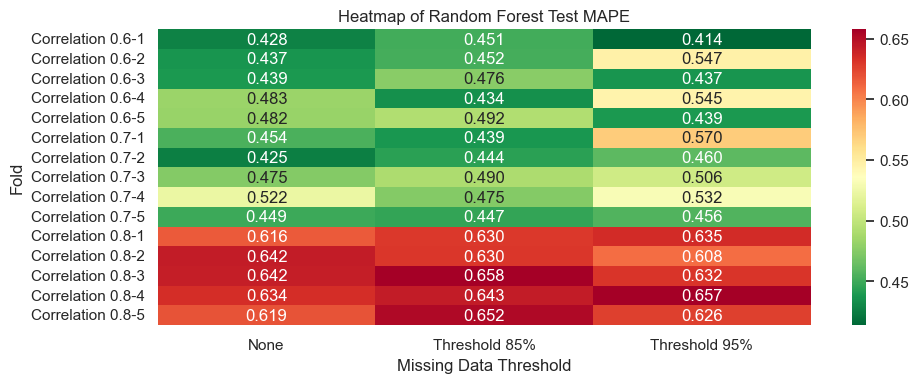

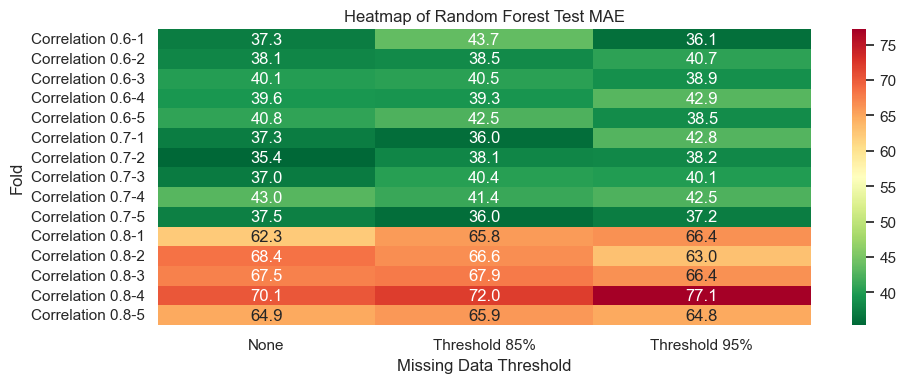

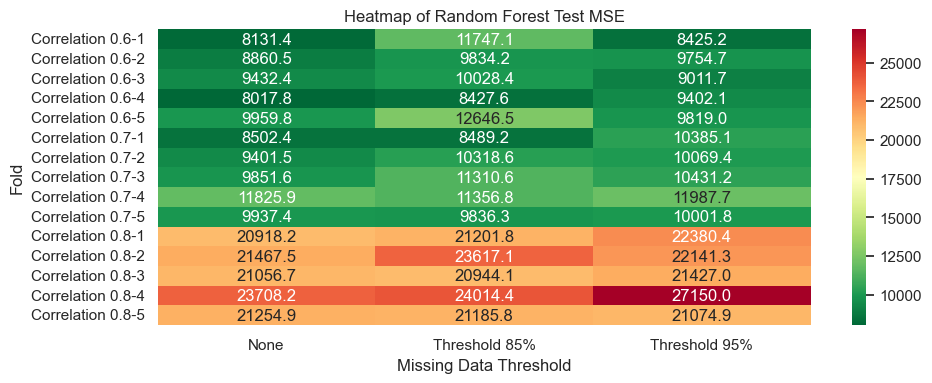

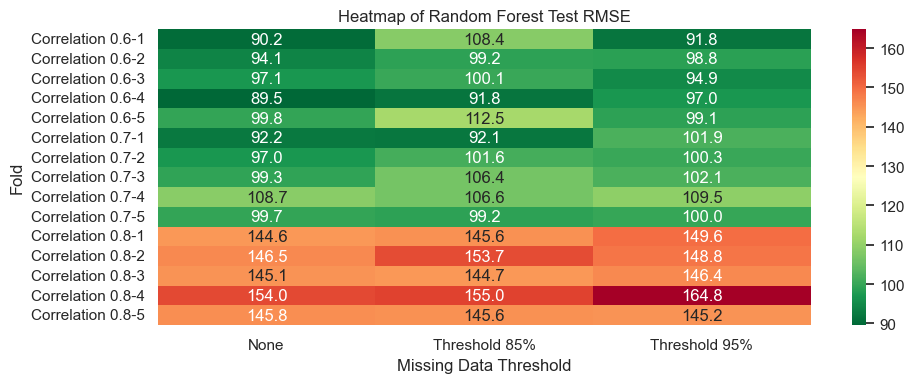

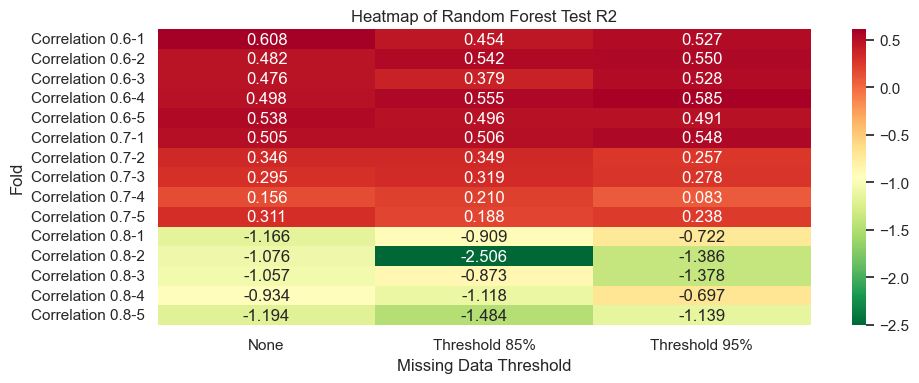

In [200]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [201]:
mean_summary

MAPE    MAE       MSE    RMSE    R2
Correlation Subset Missing Data Threshold                                     
Correlation 0.6    None                    0.45  39.19   8880.39   94.15  0.52
                   Threshold 85%           0.46  40.90  10536.76  102.39  0.49
                   Threshold 95%           0.48  39.41   9282.55   96.31  0.54
Correlation 0.7    None                    0.47  38.04   9903.75   99.37  0.32
                   Threshold 85%           0.46  38.37  10262.29  101.16  0.31
                   Threshold 95%           0.50  40.16  10575.07  102.78  0.28
Correlation 0.8    None                    0.63  66.63  21681.09  147.20 -1.09
                   Threshold 85%           0.64  67.64  22192.62  148.91 -1.38
                   Threshold 95%           0.63  67.53  22834.72  150.94 -1.06

In [180]:
mean_original = joblib.load('../../../split_income_models/base_mean_metrics.pkl')
std_original = joblib.load('../../../split_income_models/base_std_metrics.pkl')

In [202]:
no_corr_df = mean_original['LightGBM']
no_corr_df['Correlation Subset'] = 'No Correlation'
no_corr_df.set_index('Correlation Subset', append=True, inplace=True)
no_corr_df = no_corr_df.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
no_corr_df

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_62787/2733510745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_df['Correlation Subset'] = 'No Correlation'


Metric                                     MAPE    MAE       MSE    RMSE    R2
Correlation Subset Missing Data Threshold                                     
No Correlation     None                    0.48  39.29   9133.93   95.39  0.67
                   Threshold 85%           0.54  47.39  10508.41  101.84  0.62
                   Threshold 95%           0.47  38.55   8311.36   91.10  0.70

In [203]:
all_data = pd.concat([mean_summary, no_corr_df])
all_data

MAPE    MAE       MSE    RMSE    R2
Correlation Subset Missing Data Threshold                                     
Correlation 0.6    None                    0.45  39.19   8880.39   94.15  0.52
                   Threshold 85%           0.46  40.90  10536.76  102.39  0.49
                   Threshold 95%           0.48  39.41   9282.55   96.31  0.54
Correlation 0.7    None                    0.47  38.04   9903.75   99.37  0.32
                   Threshold 85%           0.46  38.37  10262.29  101.16  0.31
                   Threshold 95%           0.50  40.16  10575.07  102.78  0.28
Correlation 0.8    None                    0.63  66.63  21681.09  147.20 -1.09
                   Threshold 85%           0.64  67.64  22192.62  148.91 -1.38
                   Threshold 95%           0.63  67.53  22834.72  150.94 -1.06
No Correlation     None                    0.48  39.29   9133.93   95.39  0.67
                   Threshold 85%           0.54  47.39  10508.41  101.84  0.62
                   Threshold 95%           0.47  38.55   8311.36   91.10  0.70

In [204]:
no_corr_std = std_original['LightGBM']
no_corr_std['Correlation Subset'] = 'No Correlation'
no_corr_std.set_index('Correlation Subset', append=True, inplace=True)
no_corr_std = no_corr_std.reorder_levels(['Correlation Subset', 'Missing Data Threshold'])
all_std_data = pd.concat([std_summary, no_corr_std])

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_62787/1621931639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_corr_std['Correlation Subset'] = 'No Correlation'


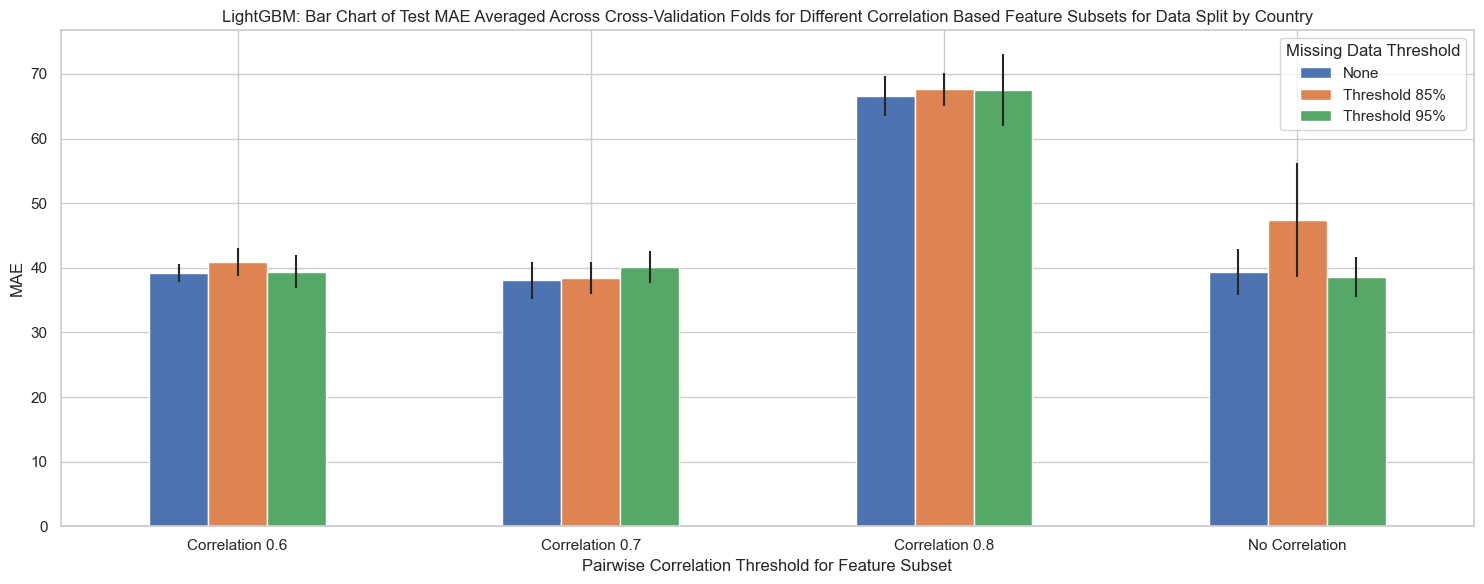

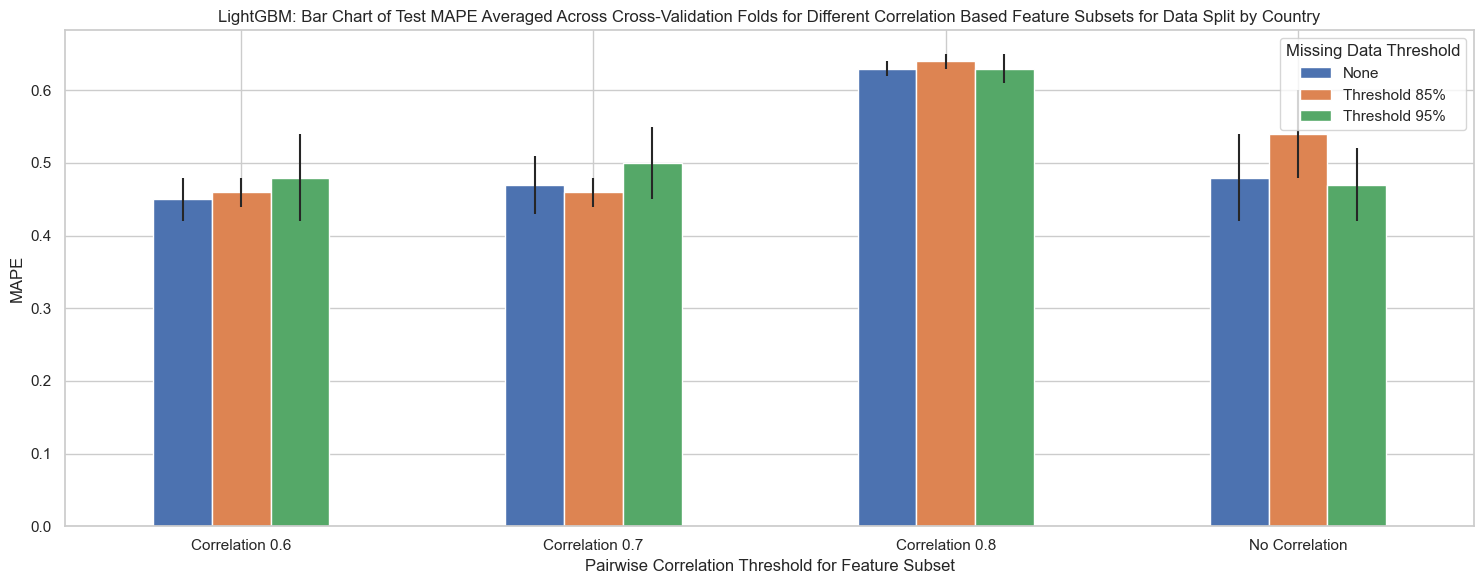

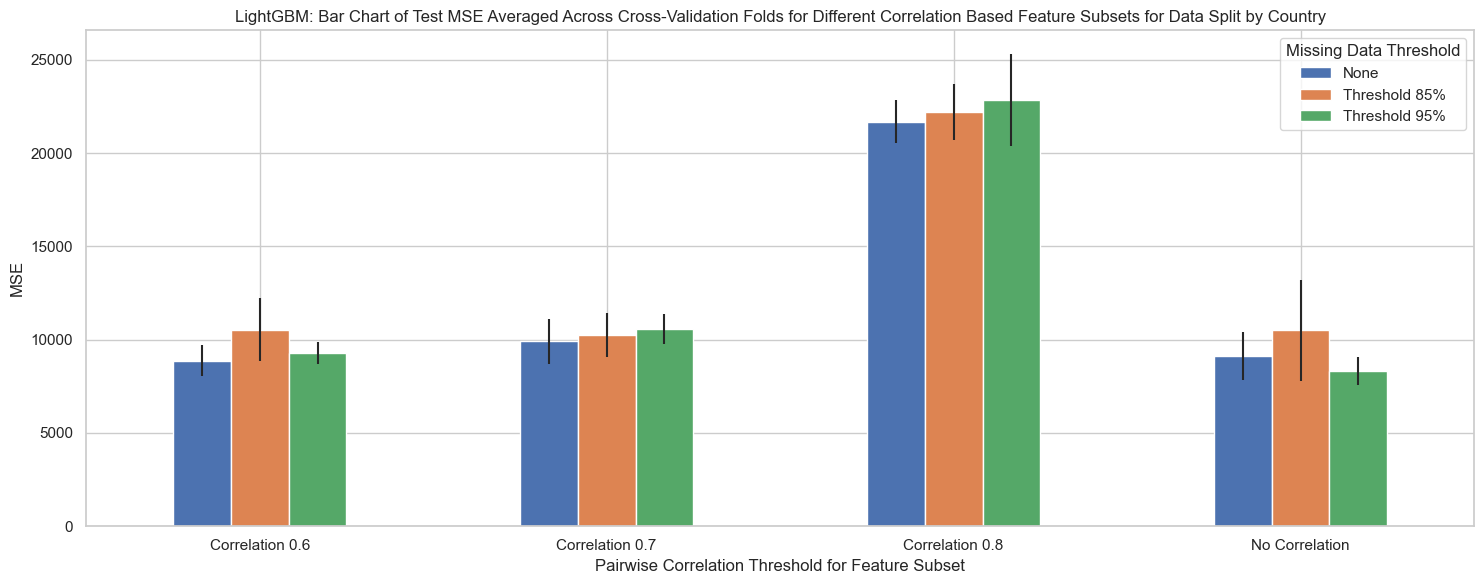

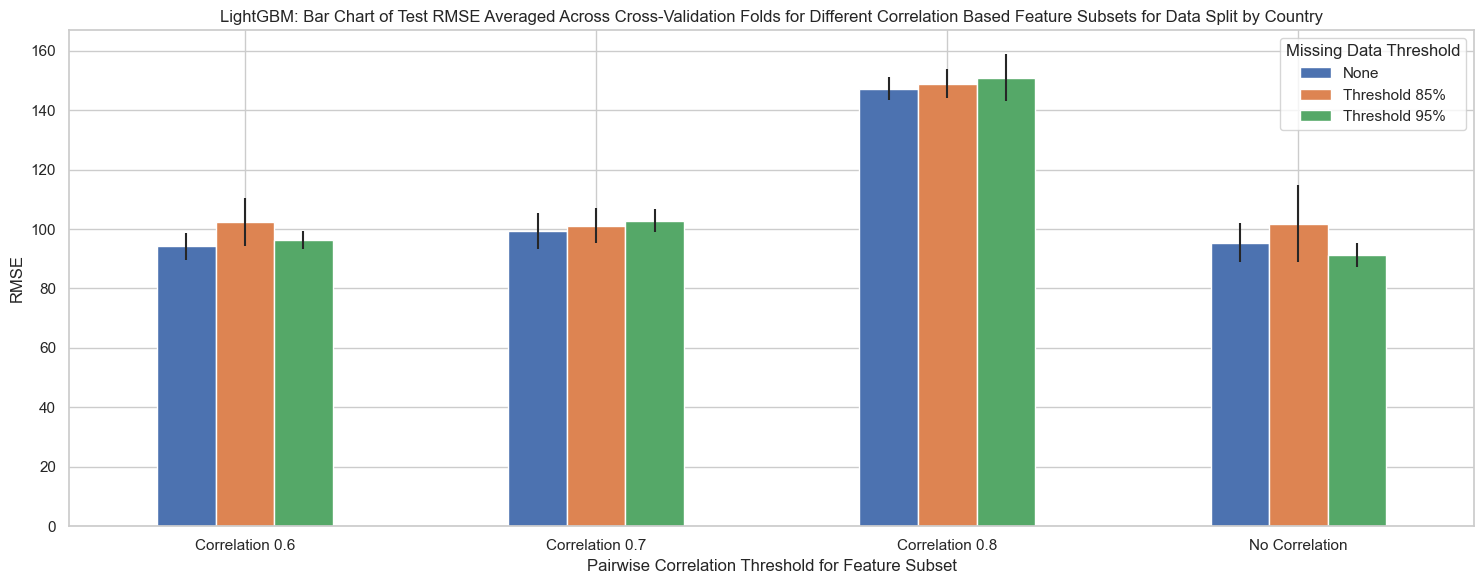

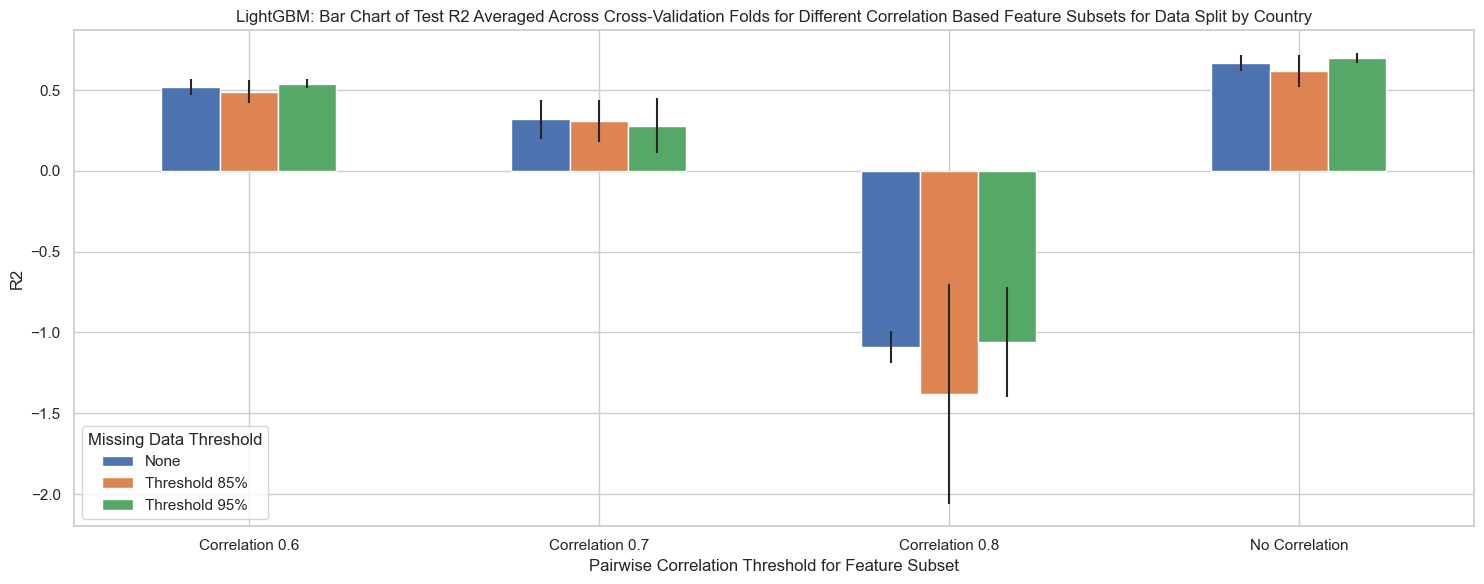

In [205]:
mean_data = all_data.astype(float)
std_data = all_std_data.astype(float)

for metric in ['MAE', 'MAPE', 'MSE', 'RMSE', 'R2']:
    mean_vals = mean_data[metric].unstack(level='Missing Data Threshold')
    std_vals = std_data[metric].unstack(level='Missing Data Threshold')
    mean_vals.plot.bar(yerr=std_vals, figsize=(15, 6), rot=0)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds for Different Correlation Based Feature Subsets for Data Split by Country")
    plt.xlabel("Pairwise Correlation Threshold for Feature Subset")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()